In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Load the datasets
x_train = np.load("x_train.npy")
x_test = np.load("x_test.npy")
y_train = np.load("y_train.npy").reshape(-1, 1)
y_test = np.load("y_test.npy").reshape(-1, 1)

# Define the base model, downloading weights if not locally available
input_shape = x_train.shape[1:]
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#base_model = VGG16(include_top=False, weights="vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", input_shape=input_shape)
base_model.trainable = False


In [2]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=3, 
                                                  restore_best_weights=True)

c:\Users\CYTech Student\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


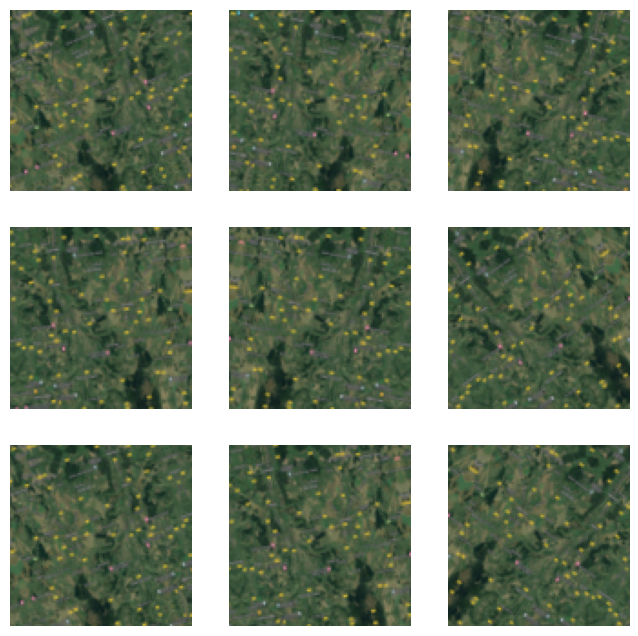

In [3]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1,input_shape=x_train.shape[1:]),
    tf.keras.layers.RandomFlip("horizontal"),
])

sample_image = x_train[0:1].copy()
plt.figure(figsize=(8, 8))
for i in range(9):
    augim = data_augmentation(sample_image, training=True)[0] # Stress training=True
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(augim)    

In [4]:
# Create the model
model = Sequential([
    data_augmentation,
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the history
history = model.fit(x_train, y_train, epochs=4, validation_data=(x_test, y_test), callbacks=[callback])

# Print training and validation loss and accuracy
print("Loss:", history.history['loss'])
print("Accuracy:", history.history['accuracy'])
print("Validation Loss:", history.history['val_loss'])
print("Validation Accuracy:", history.history['val_accuracy'])

Epoch 1/4
201/201 ━━━━━━━━━━━━━━━━━━━━ 160s 791ms/step - accuracy: 0.9118 - loss: 0.2239 - val_accuracy: 0.9719 - val_loss: 0.0840
Epoch 2/4
201/201 ━━━━━━━━━━━━━━━━━━━━ 161s 800ms/step - accuracy: 0.9763 - loss: 0.0597 - val_accuracy: 0.9925 - val_loss: 0.0313
Epoch 3/4
201/201 ━━━━━━━━━━━━━━━━━━━━ 163s 813ms/step - accuracy: 0.9883 - loss: 0.0361 - val_accuracy: 0.9906 - val_loss: 0.0283
Epoch 4/4
201/201 ━━━━━━━━━━━━━━━━━━━━ 159s 792ms/step - accuracy: 0.9897 - loss: 0.0319 - val_accuracy: 0.9913 - val_loss: 0.0246
Loss: [0.12006058543920517, 0.0498843640089035, 0.03554736077785492, 0.03459726646542549]
Accuracy: [0.9568952322006226, 0.9800093770027161, 0.9882867336273193, 0.98781818151474]
Validation Loss: [0.08404354006052017, 0.031260035932064056, 0.02829514816403389, 0.024607006460428238]
Validation Accuracy: [0.9718925952911377, 0.9925046563148499, 0.9906308650970459, 0.9912554621696472]


In [5]:
# Predict classes with the model
y_pred_ori = model.predict(x_test)
y_pred = (y_pred_ori > 0.5).astype(int)

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=['Pas carte', 'Carte'], digits=5))

51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 628ms/step
              precision    recall  f1-score   support

   Pas carte    0.99876   0.98415   0.99140       820
       Carte    0.98361   0.99872   0.99111       781

    accuracy                        0.99126      1601
   macro avg    0.99118   0.99143   0.99125      1601
weighted avg    0.99137   0.99126   0.99126      1601



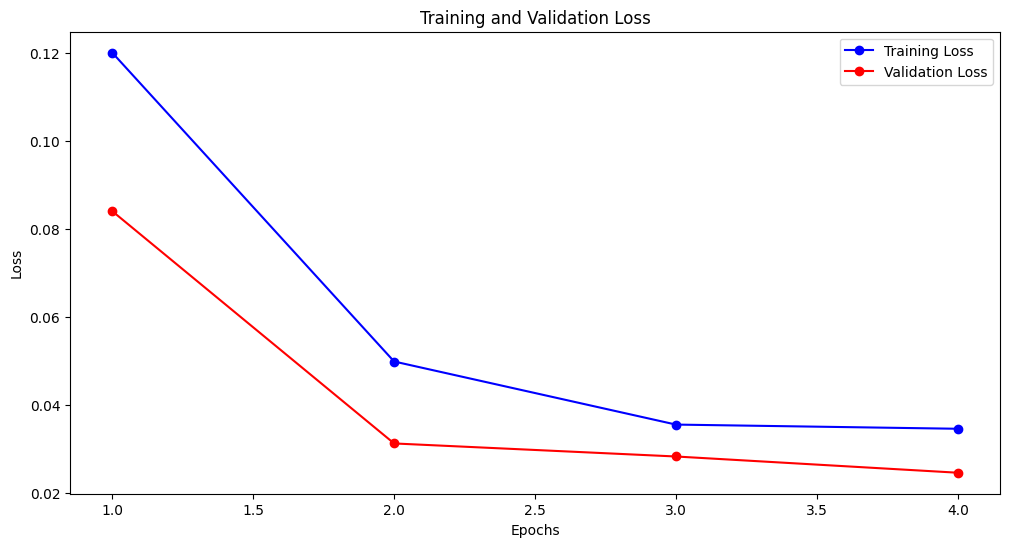

In [6]:
import matplotlib.pyplot as plt

# Extracting loss values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

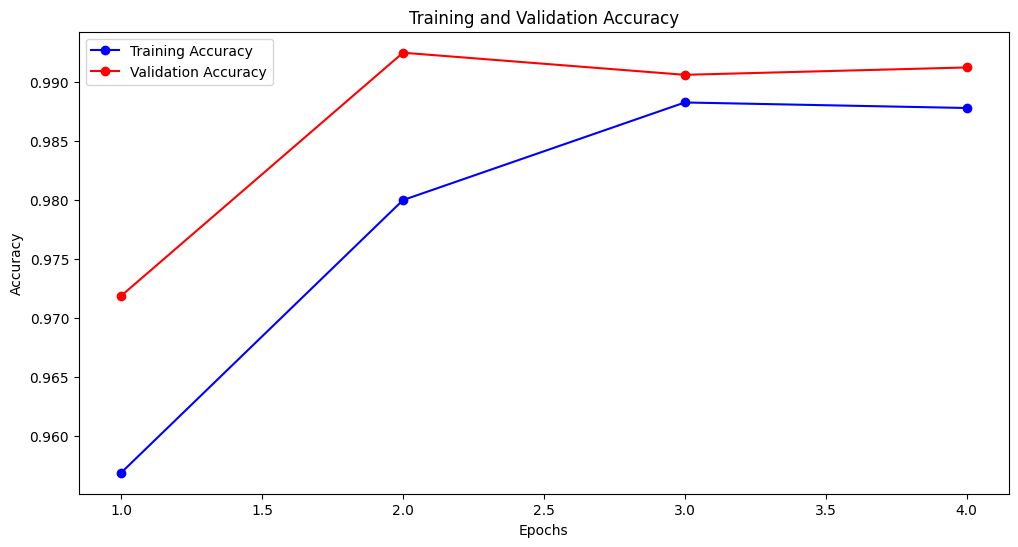

In [7]:
# Extracting loss values from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plotting the accuracy values
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
#model.save('modelVGG.keras')
#model.save_weights('modelVGG.weights.h5')

In [9]:
#from tensorflow.keras.models import load_model
#model1 = load_model('modelVGG.keras')


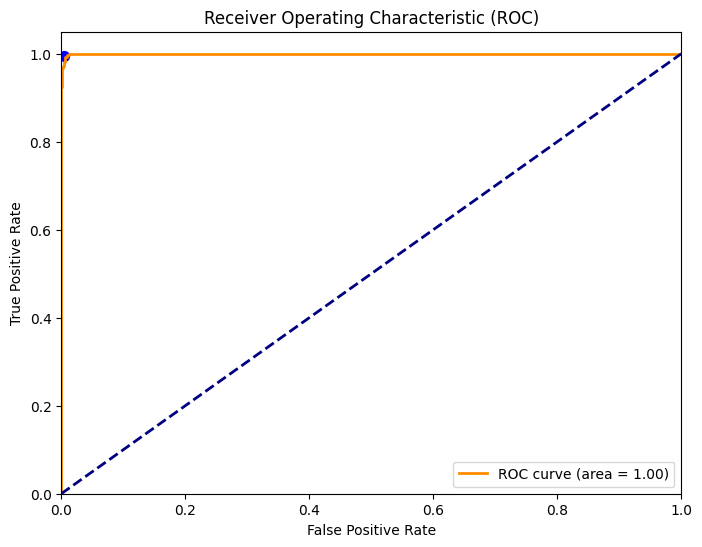

In [10]:
from sklearn.metrics import roc_curve, auc
# Calcul des taux de faux positifs (FPR) et taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ori)

# Calcul de l'aire sous la courbe ROC (AUC)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.scatter(0.004878048780487805, 0.9948783610755442, color='blue', s=50, marker='o')#Le "meilleur" threshold

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [11]:
#On cherche le point qui maximise les True Protive tout en minimisant les False Potitive, soit le point le plus proche de l'extrémité en haut à gauche
# On pourrait faire différement en faisant par exemple avec le cout des FP 3 fois plus important que le cout des FN
def distance(x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**(1/2)
def get_index_distance_mini(list_of_distances):
    distance_mini = float('inf')
    index_distance_mini = -1
    for index_distance in range(len(list_of_distances)):
        distance = list_of_distances[index_distance]
        if distance < distance_mini:
            distance_mini = distance
            index_distance_mini = index_distance
    return index_distance_mini, distance_mini
list_of_distances = [distance(fpr[index],tpr[index],0,1) for index in range(len(tpr))]
index_distance_mini,distance_mini= get_index_distance_mini(list_of_distances)

best_tpr = tpr[index_distance_mini]
best_fpr = fpr[index_distance_mini]
best_threshold = thresholds[index_distance_mini]
print("Index du meilleur point (maximise tpr et minimise fpr):",index_distance_mini)
print("distance mini:",distance_mini)
print("best tpr:",best_tpr)
print("best fpr:",best_fpr)
print("best threshold:",)

Index du meilleur point (maximise tpr et minimise fpr): 24
distance mini: 0.008841180737863143
best tpr: 0.9935979513444302
best fpr: 0.006097560975609756
best threshold:


In [12]:
# Predict classes with the model
y_pred = (y_pred_ori > best_threshold).astype(int)

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=['Pas carte', 'Carte'], digits=5))

              precision    recall  f1-score   support

   Pas carte    0.99269   0.99390   0.99330       820
       Carte    0.99359   0.99232   0.99295       781

    accuracy                        0.99313      1601
   macro avg    0.99314   0.99311   0.99313      1601
weighted avg    0.99313   0.99313   0.99313      1601



In [13]:
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Extrayez les éléments de la matrice de confusion
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 775
True Negatives: 815
False Positives: 5
False Negatives: 6


In [14]:
y_pred = model.predict(x_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 611ms/step
